# Universidad del Valle de Guatemala
## Security Data Science - 10
* Jose Abraham Gutierrez Corado - 19111

## Laboratorio 7: Ataques a modelos de Deep Learning

#### Import libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier #No soporta TF 2
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset
import numpy as np

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

#### Load model

In [20]:
vulnerable_model = tf.keras.models.load_model("target_model_redone")

#### Load Test and Train data used for the model

In [23]:
X_train = np.load('X_train_redone.npy')
X_test = np.load('X_test_redone.npy')
y_train = np.load('y_train_redone.npy')
y_test = np.load('y_test_redone.npy')

<h1 style="color:rgb(102, 166, 38);">Evasion Attack</h1>

In [24]:
classifier = KerasClassifier(vulnerable_model)

In [25]:
attack_fgsm = FastGradientMethod(
    estimator=classifier, 
    eps=0.3
    )

In [26]:
test_images_adv = attack_fgsm.generate(x=X_test)

C:\Users\Joseph\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


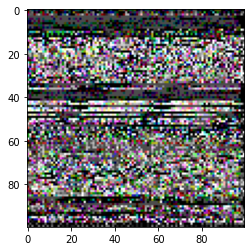

In [27]:
plt.imshow(X=test_images_adv[0])

<h3 style="color:rgb(102, 166, 38);"> Results </h3>

In [28]:
# Evaluating the model on clean images
score_clean = vulnerable_model.evaluate(
    x=X_test, 
    y=y_test
    )

# Evaluating the model on adversarial images
score_adv = vulnerable_model.evaluate(
    x=test_images_adv, 
    y=y_test
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} " 
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} " 
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

C:\Users\Joseph\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Clean test set loss: 0.07 vs adversarial set test loss: 51.67
Clean test set accuracy: 0.98 vs adversarial test set accuracy: 0.01


<h3 style="color:rgb(102, 166, 38);">Different Delta Values</h3>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

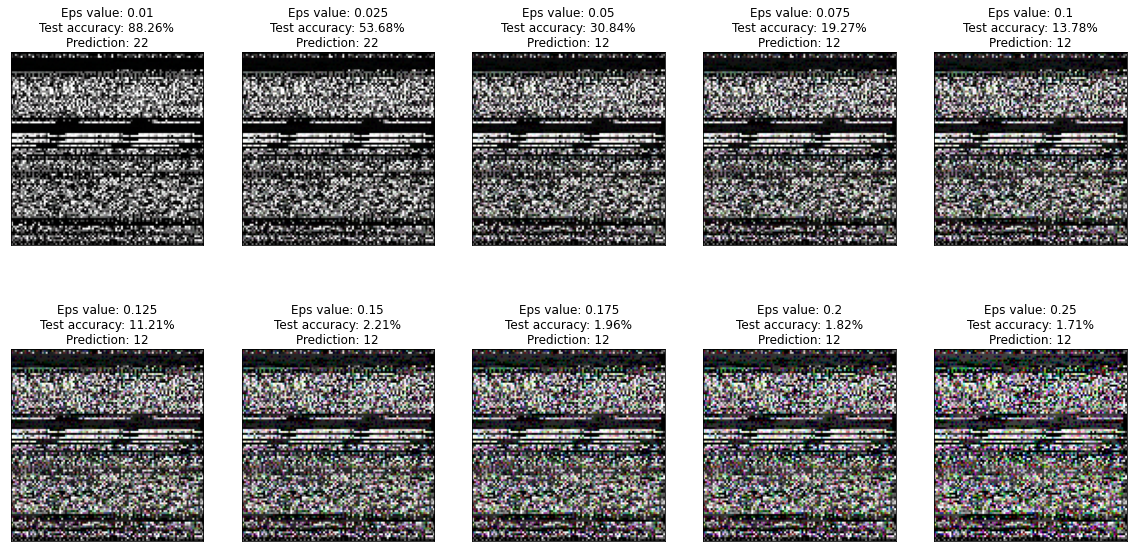

In [29]:
# Setting the number of rows and columns for the figure
nrows, ncols = 2, 5

# Generating subplots
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )

# Defining a range of eps values to try
eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]

# Defining a counting variable to traverse eps_to_try
counter = 0

# Iterating over rows and cols
for i in range(nrows):
    for j in range(ncols):    
        # Creating an attack object for the current value of eps    
        attack_fgsm = FastGradientMethod(
            estimator=classifier, 
            eps=eps_to_try[counter]
            )

        # Generating adversarial images
        test_images_adv = attack_fgsm.generate(x=X_test)

        # Showing the first adversarial image
        axes[i, j].imshow(X=test_images_adv[0])

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = classifier._model.evaluate(
            x=test_images_adv, 
            y=y_test
            )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(vulnerable_model.predict(
            x=np.expand_dims(a=test_images_adv[0], 
            axis=0)
            ))    

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        # Incrementing counter
        counter += 1

# Showing the plot
plt.show()

<h1 style="color:rgb(252, 186, 3);">Inference Attack</h1>

In [213]:
from art.attacks.inference.model_inversion import MIFace

# Defining a model inversion attack
attack = MIFace(
    classifier=classifier,
    max_iter=250, 
    batch_size=256)

In [209]:
# Defining the target labels for model inversion. Stop is 25 because there are 25 malware families
y = np.arange(start=0, stop=25)

# Inspecting the target labels
print(y)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


In [210]:
# Defining an initialization array for model inversion
x_init_average = np.zeros(shape=(25, 100, 100, 3)) + np.mean(a=X_test, axis=0)

In [211]:
%%time
# Running model inversion
x_infer_from_average = attack.infer(
    x=x_init_average, 
    y=y
    )

Model inversion:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 22min 42s
Wall time: 4min 59s


<h3 style="color:rgb(252, 186, 3);"> Results </h3>

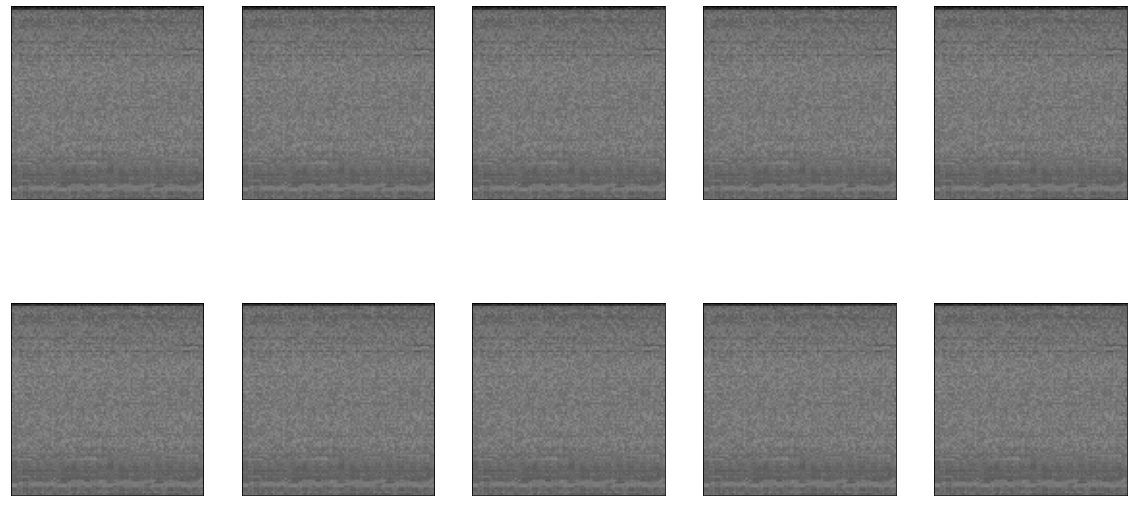

In [212]:
nrows, ncols = 2, 5
# Creating a figure and axes for our plot
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )

# Declaring a counting variable
counter = 0

# Iterating over the axes and plotting the inferred images in them
for i in range(nrows):
    for j in range(ncols):        
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])
        axes[i, j].imshow(X=x_infer_from_average[counter])

        # Incrementing the counter
        counter += 1

# Showing the plotted axes
plt.show()